In [2]:
# coding:utf8
import numpy as np
import math
from math import pi
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.models import LinearAxis, LogAxis, Range1d
from scipy.fftpack import fft, fftfreq, fftshift, rfft
output_file('Fourier.html')
%matplotlib notebook

In [3]:
tick = pd.read_csv('RIM6_4.trd', usecols=(0, 1, 2, 3, 4, 5, 6),
                   parse_dates={'DateTime': [0, 1]}, index_col=False)
tick = tick.rename(columns={'<LAST>': 'Price', '<VOL>': 'Vol', '<DIRECTION>': 'Dir'})
tick.ix[tick.Dir == 'Sell', 'VolSell'] = tick.Vol
tick.ix[tick.Dir == 'Buy', 'VolBuy'] = tick.Vol
tick.fillna(0)
tick.to_csv('tick.csv', na_rep='0.0', columns=('DateTime', 'Price', 'VolBuy', 'VolSell'))
tick.head()

,DateTime,<MSEC>,<TRADENO>,Price,Vol,Dir,VolSell,VolBuy
0,2016-04-20 10:00:00,1,1462284886,91860,1,Sell,1.0,NaN
1,2016-04-20 10:00:00,1,1462284887,91840,2,Sell,2.0,NaN
2,2016-04-20 10:00:00,1,1462284888,91830,1,Sell,1.0,NaN
3,2016-04-20 10:00:00,1,1462284889,91750,1,Sell,1.0,NaN
4,2016-04-20 10:00:00,1,1462284890,91700,3,Sell,3.0,NaN


In [3]:
Nticks = 500     # Количество тиков для бара и ресэмплинг по тикам
Nback = 64
Ndeltas = 1000
TimeRes = '1s'  # Интервал ресэмплинга в секундах
dt = 1.0        # Interval FFT
fs = 1.0/dt      # Sampling frequency
dl = tick.fillna(0)
dl['Delta'] = dl['VolBuy'] - dl['VolSell']
dl['CumDelta'] = (dl['VolBuy'] - dl['VolSell']).cumsum()
dl['AbsCumDelta'] = abs(dl['Delta']).cumsum()
dl.iloc[:1000].to_csv('Deltas1.csv')
ff = (dl['VolSell'].iloc[0:10] != 0).sum()
ff

10

In [106]:
rows_list = []
for i in range(0, int((dl.AbsCumDelta.max()/Ndeltas))) :
    tmp = dl.loc[(dl['AbsCumDelta'] > i*Ndeltas) & (dl['AbsCumDelta'] <= i*Ndeltas + Ndeltas)]
    dict1 = {}

    op = tmp.Price.iloc[0]
    hi = tmp.Price.max()
    lo = tmp.Price.min()
    cl = tmp.Price.iloc[(len(tmp.index) - 1)]
    cumdelta = tmp.CumDelta.iloc[(len(tmp.index) - 1)]
    vBuy = tmp.VolBuy.sum()
    vSell = tmp.VolSell.sum()
    nBuy = (tmp.VolBuy.iloc[0:(len(tmp.index) - 1)] !=0).sum()
    nSell = (tmp.VolSell.iloc[0:(len(tmp.index) - 1)] !=0).sum()
    tClose = tmp.DateTime.max()
    dtime = (tmp.DateTime.max() - tmp.DateTime.min())
    dict1.update({'DateTime': tClose, 'open': op, 'high': hi,
                  'low': lo, 'close': cl, 'TickBuy': nBuy,
                  'VolBuy': vBuy, 'TickSell': nSell, 'VolSell': vSell, 'DeltaTime': dtime, 'CumDelta': cumdelta})
    rows_list.append(dict1)

res = pd.DataFrame(rows_list)

res['Dsec'] = res['DeltaTime'].dt.total_seconds()
res['TSpeedBuy'] = res['TickBuy'] / res['Dsec']
res['TSpeedSell'] = res['TickSell'] / res['Dsec']
res['VSpeedBuy'] = res['VolBuy'] / res['Dsec']
res['VSpeedSell'] = res['VolSell'] / res['Dsec']
res['OTO'] = ((res['TickBuy'] - res['TickSell']) / (res['TickBuy'] + res['TickSell']) * 0.65
              + (res['VolBuy'] - res['VolSell']) / (res['VolBuy'] + res['VolSell']) * 0.35) * 100.0
res['OTON'] = ((res['TickBuy'] * res['VolBuy'] - res['TickSell'] * res['VolSell']) /
               (res['TickBuy'] * res['VolBuy'] + res['TickSell'] * res['VolSell']))
res.to_csv('res.csv')
res.tail()

,CumDelta,DateTime,DeltaTime,TickBuy,TickSell,VolBuy,VolSell,close,high,low,open,Dsec,TSpeedBuy,TSpeedSell,VSpeedBuy,VSpeedSell,OTO,OTON
1240,51668.0,2016-04-20 23:42:00,00:01:39,290,116,729.0,276.0,94660,94690,94600,94600,99.0,2.929293,1.171717,7.363636,2.787879,43.633262,0.736955
1241,51472.0,2016-04-20 23:43:59,00:01:58,148,166,403.0,599.0,94640,94660,94580,94650,118.0,1.254237,1.406780,3.415254,5.076271,-10.572422,-0.250129
1242,51190.0,2016-04-20 23:45:57,00:01:58,173,168,359.0,641.0,94600,94670,94600,94640,118.0,1.466102,1.423729,3.042373,5.432203,-8.916921,-0.268447
1243,51210.0,2016-04-20 23:48:59,00:03:01,160,222,510.0,490.0,94570,94660,94570,94600,181.0,0.883978,1.226519,2.817680,2.707182,-9.849738,-0.142767
1244,51161.0,2016-04-20 23:49:57,00:00:58,131,167,466.0,515.0,94550,94650,94530,94570,58.0,2.258621,2.879310,8.034483,8.879310,-9.600565,-0.169730


<IPython.core.display.Javascript object>


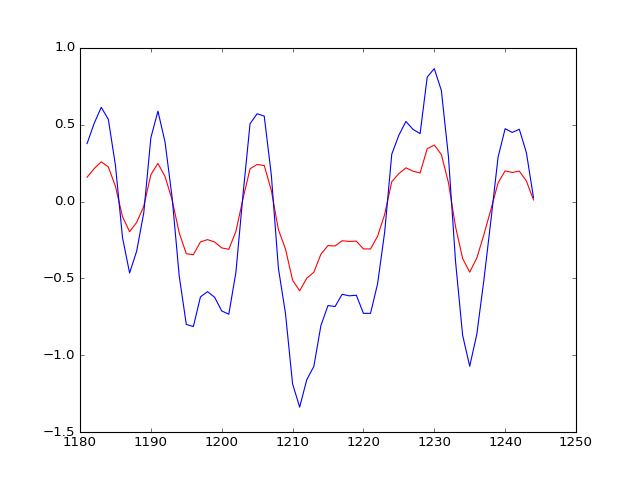

In [110]:
# res = res.set_index('DateTime')
mids = (res.open + res.close)/2
spans = abs(res.close - res.open)
inc = res.close > res.open
dec = res.open > res.close
#w = 12*60*60
w = 0.5
x = np.linspace(1181, 1244, 64)
r = np.sin(2*pi*0.051724138*h)+np.sin(2*pi*0.051724138*h)+np.sin(2*pi*0.12068966*h)+np.sin(2*pi*0.15517241*h)
res[-64:].OTON.rolling(window=4).mean().rolling(window=4).mean().to_csv('New.csv')
res['OTOA']=res.OTON.rolling(window=4).mean().rolling(window=4).mean()
h=res['OTOA'][-64:]
plt.plot(h, 'r')
plt.plot(x, r)

In [7]:
p = figure(x_range=(0, len(res.index)), plot_width=2048, plot_height=1300, title='RIM6 CandleStick')
p.y_range=Range1d(start=90500, end=96000)
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha = 0.9
p.segment(res.index.values, res.high, res.index.values, res.low, color='black')
p.rect(res.index[inc], mids[inc], w, spans[inc], fill_color='#6CF350', line_color='green')
p.rect(res.index[dec], mids[dec], w, spans[dec], fill_color='#FF0000', line_color='red')
p.extra_y_ranges = {}
p.extra_y_ranges['TickSpeed'] = Range1d(start=0, end=100)
p.extra_y_ranges['OTO'] = Range1d(start=-60, end=60)
p.extra_y_ranges['OTON'] = Range1d(start=-60, end=60)
p.extra_y_ranges['CumDelta'] = Range1d(start=-3000, end=52000)
#p.line(res.index, res.TSpeedBuy, color='blue', y_range_name='TickSpeed', alpha=0.5)
p.line(res.index, res.TSpeedBuy.rolling(window=4).median(), color='green', y_range_name='TickSpeed', alpha=0.8)
#p.line(res.index, res.TSpeedSell, color='red', y_range_name='TickSpeed', alpha=0.5)
p.line(res.index, res.TSpeedSell.rolling(window=9).median(), color='red', y_range_name='TickSpeed', alpha=0.8)
p.line(res.index, res.OTO.rolling(window=15).mean(), color='brown', y_range_name='OTO', alpha=0.9)
p.line(res.index, res.OTON.rolling(window=15).mean(), color='blue', y_range_name='OTON', alpha=0.9)
p.line(res.index, res.CumDelta, color='black', y_range_name='CumDelta', alpha=0.9)
p.add_layout(LogAxis(y_range_name='TickSpeed'), 'left')
p.add_layout(LinearAxis(y_range_name='OTO'), 'left')
p.add_layout(LinearAxis(y_range_name='OTON'), 'left')
p.add_layout(LinearAxis(y_range_name='CumDelta'), 'left')
#show(p)
#l=figure(plot_width=800, plot_height=600, title='FFT')
#l.line(resfftfreq, resfft)
#m = gridplot([[p, l]])

show(p)